In [1]:
#Human in the loop
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
@tool
def get_stock_price(symbol: str)-> float:
    """
    Return the current price of a stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    """
    return {
        "MSFT":200.3,
        "AMZN":150.0,
        "RIL":87.6,
        "AAPL":100.8
    }.get(symbol,0.0)


@tool
def buy_stocks(symbol: str,quantity:int,total_price: float)->str:
    """
    Buy stocks given the stock symbol and quantity
    """
    decision=interrupt(f"Approve buying {quantity} {symbol} stocks for${total_price:.2f}?")
    if decision=="yes":
        
       return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."

tools=[get_stock_price,buy_stocks]



In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools=llm.bind_tools(tools=tools)
print(llm_with_tools)

bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000021A837F8710>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021A8394D100>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'Return the current price of a stock symbol\n:param symbol: stock symbol\n:return: current price of the stock', 'parameters': {'properties': {'symbol': {'type': 'string'}}, 'required': ['symbol'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'buy_stocks', 'description': 'Buy stocks given the stock symbol and quantity', 'parameters': {'properties': {

In [6]:
#node functionality
memory=MemorySaver()
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [7]:
graph_builder=StateGraph(State)

graph_builder.add_node(chatbot)
graph_builder.add_node("tools",ToolNode(tools))


graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

#compile the graph
graph=graph_builder.compile(checkpointer=memory)

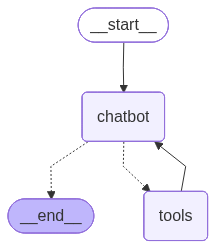

In [8]:
#display the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [11]:
#user asks price
config={"configurable":{"thread_id":"1"}}
res=graph.invoke({"messages":[{"role":"user","content":"What is the current price of AMZN stocks?"}]},config=config)
print(res["messages"][-1].content)

The current price of AMZN stocks is $150.0.


In [12]:
res=graph.invoke({"messages":[{"role":"user","content":"Buy 10 AMZN stock at current price."}]},config=config)
print(res.get("__interrupt__"))

[Interrupt(value='Approve buying 10 AMZN stocks for$1500.00?', id='168faca970df3aa6af140b2ef5417b82')]


In [13]:
decision=input("Approve (yes/No): ")
res2=graph.invoke(Command(resume=decision),config=config)
print(res2["messages"][-1].content)

You now own 10 shares of AMZN, and your total investment is $1500.
